# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

--2020-07-22 14:54:22--  https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba
Resolving codalab.coresearch.club (codalab.coresearch.club)... 

51.116.181.68
Connecting to codalab.coresearch.club (codalab.coresearch.club)|51.116.181.68|:443... 

connected.


HTTP request sent, awaiting response... 

302 FOUND
Location: https://minio.coresearch.club:443/private/public_data/193/ca1cf/competition/98/1/data/public_data.zip [following]
--2020-07-22 14:54:23--  https://minio.coresearch.club/private/public_data/193/ca1cf/competition/98/1/data/public_data.zip
Resolving minio.coresearch.club (minio.coresearch.club)... 

51.116.181.68
Connecting to minio.coresearch.club (minio.coresearch.club)|51.116.181.68|:443... 

connected.


HTTP request sent, awaiting response... 

200 OK
Length: 23166579 (22M) [application/zip]
Saving to: ‘input_public_data.zip’

input_public_data.z   0%[                    ]       0  --.-KB/s               

input_public_data.z   0%[                    ]  39.57K   173KB/s               

input_public_data.z   0%[                    ] 187.57K   430KB/s               

input_public_data.z   1%[                    ] 451.38K   669KB/s               

input_public_data.z   3%[                    ] 819.38K   897KB/s               

input_public_data.z   6%[>                   ]   1.35M  1.17MB/s               

input_public_data.z   9%[>                   ]   2.21M  1.58MB/s               

input_public_data.z  15%[==>                 ]   3.39M  2.09MB/s               

input_public_data.z  22%[===>                ]   4.96M  2.62MB/s               

input_public_data.z  33%[=====>              ]   7.32M  3.44MB/s               

input_public_data.z  43%[=======>            ]   9.60M  4.01MB/s               

input_public_data.z  54%[=========>          ]  12.00M  4.53MB/s               

input_public_data.z  66%[============>       ]  14.79M  5.11MB/s               

input_public_data.z  72%[=============>      ]  16.00M  5.08MB/s    eta 1s     

input_public_data.z  77%[==============>     ]  17.05M  5.03MB/s    eta 1s     

input_public_data.z  82%[===============>    ]  18.14M  4.99MB/s    eta 1s     

input_public_data.z  87%[================>   ]  19.29M  4.98MB/s    eta 1s     

input_public_data.z  90%[=================>  ]  20.00M  4.86MB/s    eta 1s     

input_public_data.z  96%[==================> ]  21.22M  4.88MB/s    eta 0s     

input_public_data.z 100%[===================>]  22.09M  4.93MB/s    in 4.5s    



2020-07-22 14:54:29 (4.93 MB/s) - ‘input_public_data.zip’ saved [23166579/23166579]



Archive:  input_public_data.zip


  inflating: data_test.npz           


  inflating: data_train.npz          

In [2]:
import numpy as np

In [4]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [5]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [6]:
import matplotlib.pyplot as plt

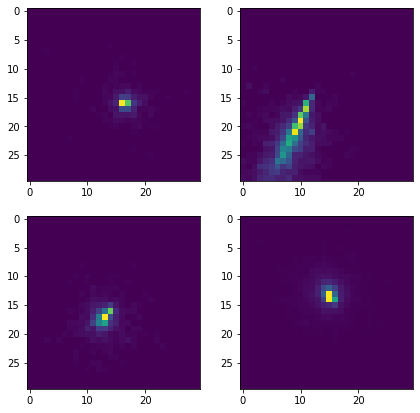

In [7]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(energy[5])
plt.subplot(222)
plt.imshow(energy[50])
plt.subplot(223)
plt.imshow(energy[500])
plt.subplot(224)
plt.imshow(energy[5000]);

It's also worth knowing how the targets are distributed:

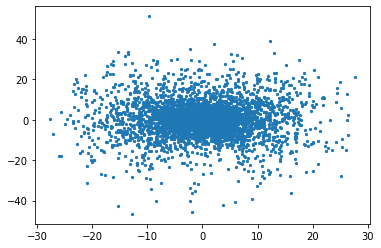

In [8]:
plt.scatter(*momentum.T, s=5);

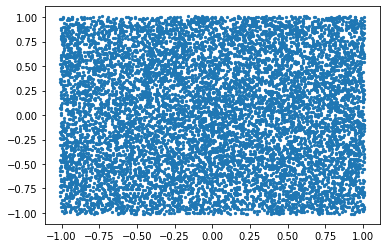

In [9]:
plt.scatter(*coordinate.T, s=5);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

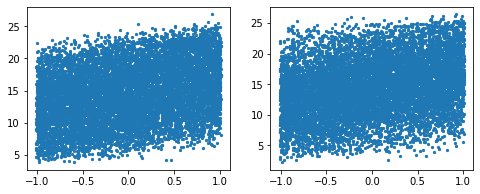

In [10]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

# Example solution

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [12]:
X = energy[:,None,...] # adding Channels dimension
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8924, 1, 30, 30) (8924, 4) (992, 1, 30, 30) (992, 4)


In [13]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 1024

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

In [14]:
# Disclaimer: this might not be the best architecture for the task

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=3,
                               kernel_size=7)
        self.pool = nn.MaxPool2d((4, 4))
        self.conv2 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=4)

        self.fc1 = nn.Linear(3 * 3 * 8, 32)
        self.fc2 = nn.Linear(32, 2 + 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(len(x), -1)

        x = F.relu(self.fc1(x))

        return self.fc2(x)

In [15]:
device = torch.device('cuda:0')
# device = torch.device('cpu:0')
device

device(type='cuda', index=0)

In [16]:
regressor = Regressor().to(device)

In [17]:
learning_rate = 1e-3
opt = optim.Adam(regressor.parameters(), lr=learning_rate)

In [18]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [19]:
# Disclaimer: this might not be the best loss function for this task.
loss_fn = torch.nn.L1Loss().to(device)

In [21]:
def run_training(epochs=5):
    losses_train = []
    losses_val = []
    metrics_train = []
    metrics_val = []
    per_component_metrics_train = []
    per_component_metrics_val = []

    for epoch in tqdm(range(epochs)):
        for batch_X, batch_Y in ds_train:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(pred, batch_Y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses_train.append(loss.item())
            metrics_train.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )

            per_component_metrics_train.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )

        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        for batch_X, batch_Y in ds_val:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(pred, batch_Y)

            avg_loss.append(loss.item())
            avg_metrics.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )
            avg_per_component_metrics.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )
        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(
            np.mean(avg_per_component_metrics, axis=0)
        )


        clear_output()
        plt.figure(figsize=(18, 4.5))

        plt.subplot(131)

        plt.title("Loss")
        plt.plot(losses_train, label='train')
        plt.plot(
            np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
            losses_val, label='val'
        )
        plt.legend()

        plt.subplot(132)

        plt.title("Metric (per component)")
        ms_train = np.array(per_component_metrics_train).T
        ms_val = np.array(per_component_metrics_val).T
        for i, (m_train, m_val, color) in enumerate(zip(ms_train,
                                                        ms_val,
                                                        plt.rcParams['axes.prop_cycle'])):
            plt.plot(m_train, label=f'train (component {i})', c=color['color'])
            plt.plot(
                np.linspace(0, len(m_train), len(m_val), endpoint=False),
                m_val, '--', label=f'val (component {i})', c=color['color']
            )
        plt.legend()

        plt.subplot(133)

        plt.title("Metric (total)")
        plt.plot(metrics_train, label='train')
        plt.plot(
            np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
            metrics_val, label='val'
        )
        plt.legend()
        plt.show()

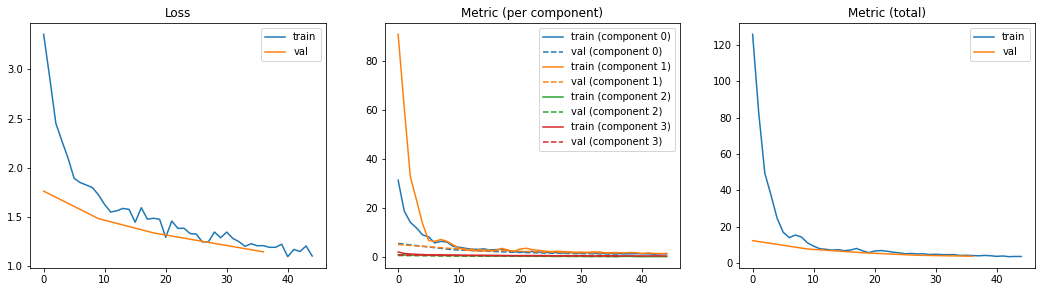

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

In [22]:
run_training(5)

In [23]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]

In [24]:
prediction_test = regressor(torch.tensor(X_test, device=device).float()).cpu()

In [25]:
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

In [26]:
np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)